<a href="https://colab.research.google.com/github/wolfram3002/Atomic_Heart/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')

In [4]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0


In [9]:
df['is_big_weight'] = np.where(df['WT_50'] >= 165, 1, 0)
df.is_big_weight = df.is_big_weight.astype('category')
df['DEATH'] = df['DEATH'].astype('category')

In [10]:
Y = df['is_big_weight'] # выбираем целевую переменную (категориальную)
X = df.drop('is_big_weight', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('WT_50', axis=1)

In [11]:
df.drop('WT_50', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   AGE_50         200 non-null    int64   
 1   MD_50          200 non-null    int64   
 2   SBP_50         200 non-null    int64   
 3   DBP_50         200 non-null    int64   
 4   HT_50          200 non-null    int64   
 5   CHOL_50        200 non-null    int64   
 6   SES            200 non-null    int64   
 7   CL_STATUS      200 non-null    int64   
 8   MD_62          200 non-null    int64   
 9   SBP_62         200 non-null    int64   
 10  DBP_62         200 non-null    int64   
 11  CHOL_62        200 non-null    int64   
 12  WT_62          200 non-null    int64   
 13  IHD_DX         200 non-null    int64   
 14  DEATH          200 non-null    category
 15  is_big_weight  200 non-null    category
dtypes: category(2), int64(14)
memory usage: 22.6 KB


In [12]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH,is_big_weight
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1,0
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0,0


## 2: масштабирование признаков

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AGE_50     200 non-null    int64   
 1   MD_50      200 non-null    int64   
 2   SBP_50     200 non-null    int64   
 3   DBP_50     200 non-null    int64   
 4   HT_50      200 non-null    int64   
 5   CHOL_50    200 non-null    int64   
 6   SES        200 non-null    int64   
 7   CL_STATUS  200 non-null    int64   
 8   MD_62      200 non-null    int64   
 9   SBP_62     200 non-null    int64   
 10  DBP_62     200 non-null    int64   
 11  CHOL_62    200 non-null    int64   
 12  WT_62      200 non-null    int64   
 13  IHD_DX     200 non-null    int64   
 14  DEATH      200 non-null    category
dtypes: category(1), int64(14)
memory usage: 22.3 KB


In [16]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [17]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH_1
0,42,1,110,65,64,291,2,8,4,120,78,271,146,2,True
1,53,1,130,72,69,278,1,6,2,122,68,250,165,9,True
2,53,2,120,90,70,342,4,8,1,132,90,304,223,2,True
3,48,4,120,80,72,239,4,8,2,118,68,209,227,3,True
4,53,3,118,74,66,243,3,8,5,118,56,261,138,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,300,2,8,1,115,65,273,152,0,False
196,23,1,110,70,69,120,3,8,2,112,76,198,153,0,False
197,20,3,130,80,66,210,5,0,1,130,85,274,158,0,False
198,46,3,140,84,66,130,4,6,2,148,88,160,157,0,False


In [19]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [20]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH_1
0,0.448980,0.000000,0.180328,0.264706,0.214286,0.412048,0.25,1.00,0.75,0.31250,0.318841,0.576419,0.275362,0.222222,True
1,0.673469,0.000000,0.344262,0.333333,0.571429,0.380723,0.00,0.75,0.25,0.32500,0.173913,0.484716,0.413043,1.000000,True
2,0.673469,0.333333,0.262295,0.509804,0.642857,0.534940,0.75,1.00,0.00,0.38750,0.492754,0.720524,0.833333,0.222222,True
3,0.571429,1.000000,0.262295,0.411765,0.785714,0.286747,0.75,1.00,0.25,0.30000,0.173913,0.305677,0.862319,0.333333,True
4,0.673469,0.666667,0.245902,0.352941,0.357143,0.296386,0.50,1.00,1.00,0.30000,0.000000,0.532751,0.217391,0.222222,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.612245,0.000000,0.221311,0.411765,0.357143,0.433735,0.25,1.00,0.00,0.28125,0.130435,0.585153,0.318841,0.000000,False
196,0.061224,0.000000,0.180328,0.313725,0.571429,0.000000,0.50,1.00,0.25,0.26250,0.289855,0.257642,0.326087,0.000000,False
197,0.000000,0.666667,0.344262,0.411765,0.357143,0.216867,1.00,0.00,0.00,0.37500,0.420290,0.589520,0.362319,0.000000,False
198,0.530612,0.666667,0.426230,0.450980,0.357143,0.024096,0.75,0.75,0.25,0.48750,0.463768,0.091703,0.355072,0.000000,False


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [21]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [22]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.8187
Точность на тестовой выборке: 0.8750

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.89      0.85      0.87        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [23]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [24]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [25]:
X_processed.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.531939,0.453333,0.300820,0.444902,0.511429,0.332783,0.478750,0.956250,0.328750,0.446750,0.417681,0.502489,0.430254,0.156667
std,0.220668,0.339211,0.148481,0.107848,0.197726,0.133793,0.267336,0.139965,0.299264,0.154105,0.185625,0.203099,0.199393,0.273800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367347,0.000000,0.180328,0.392157,0.357143,0.240964,0.250000,1.000000,0.000000,0.343750,0.289855,0.365721,0.295290,0.000000
50%,0.551020,0.333333,0.262295,0.411765,0.500000,0.313253,0.500000,1.000000,0.250000,0.425000,0.391304,0.491266,0.416667,0.000000
75%,0.693878,0.666667,0.344262,0.509804,0.642857,0.421687,0.500000,1.000000,0.500000,0.531250,0.492754,0.629913,0.572464,0.222222
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X_iqr.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.0,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.523021,0.453252,0.263944,0.423721,0.522648,0.321848,0.480183,1.0,0.341463,0.425953,0.400407,0.506071,0.428729,0.116531
std,0.220559,0.342188,0.104848,0.077813,0.195376,0.120752,0.250742,0.0,0.297000,0.142735,0.172545,0.198241,0.202813,0.212751
min,0.040816,0.000000,0.000000,0.166667,0.071429,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.048035,0.000000,0.000000
25%,0.362245,0.000000,0.180328,0.392157,0.357143,0.240964,0.250000,1.0,0.000000,0.334375,0.275362,0.370087,0.282609,0.000000
50%,0.540816,0.333333,0.262295,0.411765,0.571429,0.313253,0.500000,1.0,0.250000,0.403125,0.347826,0.491266,0.416667,0.000000
75%,0.678571,0.666667,0.344262,0.509804,0.642857,0.409639,0.500000,1.0,0.500000,0.500000,0.492754,0.634279,0.572464,0.222222
max,1.000000,1.000000,0.590164,0.607843,1.000000,0.768675,1.000000,1.0,1.000000,1.000000,0.927536,0.995633,1.000000,0.777778


In [27]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.8550
Точность на тестовой выборке: 0.8788

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       1.00      0.73      0.85        15

    accuracy                           0.88        33
   macro avg       0.91      0.87      0.87        33
weighted avg       0.90      0.88      0.88        33



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

Благодаря методу удаление на основе медианы мы убрали выбросы. В моем датасете выбросов оказалось чуть меньше одной пятой от всей базы данных, что повлияло на максимальные и минимальные значения, которое последовало за собой и изменения среднего значения. Изменения не очень большие, но они есть.

### Метод 2: удаление на основе среднего

In [28]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [29]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [30]:
X_processed.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.531939,0.453333,0.300820,0.444902,0.511429,0.332783,0.478750,0.956250,0.328750,0.446750,0.417681,0.502489,0.430254,0.156667
std,0.220668,0.339211,0.148481,0.107848,0.197726,0.133793,0.267336,0.139965,0.299264,0.154105,0.185625,0.203099,0.199393,0.273800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367347,0.000000,0.180328,0.392157,0.357143,0.240964,0.250000,1.000000,0.000000,0.343750,0.289855,0.365721,0.295290,0.000000
50%,0.551020,0.333333,0.262295,0.411765,0.500000,0.313253,0.500000,1.000000,0.250000,0.425000,0.391304,0.491266,0.416667,0.000000
75%,0.693878,0.666667,0.344262,0.509804,0.642857,0.421687,0.500000,1.000000,0.500000,0.531250,0.492754,0.629913,0.572464,0.222222
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
X_mean.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,0.529989,0.468193,0.271993,0.425909,0.509269,0.319893,0.494275,0.991412,0.320611,0.427052,0.398385,0.494283,0.392632,0.110263
std,0.202077,0.335324,0.112864,0.081203,0.177723,0.105197,0.233011,0.038577,0.279551,0.126245,0.169150,0.172114,0.171482,0.208324
min,0.102041,0.000000,0.098361,0.254902,0.142857,0.072289,0.000000,0.750000,0.000000,0.187500,0.057971,0.131004,0.036232,0.000000
25%,0.397959,0.333333,0.180328,0.392157,0.357143,0.240964,0.375000,1.000000,0.000000,0.340625,0.275362,0.373362,0.275362,0.000000
50%,0.530612,0.333333,0.262295,0.411765,0.571429,0.313253,0.500000,1.000000,0.250000,0.406250,0.347826,0.489083,0.391304,0.000000
75%,0.673469,0.666667,0.344262,0.509804,0.642857,0.402410,0.500000,1.000000,0.500000,0.500000,0.492754,0.602620,0.514493,0.222222
max,0.918367,1.000000,0.590164,0.656863,0.857143,0.585542,1.000000,1.000000,0.750000,0.750000,0.782609,0.868996,0.760870,0.666667


In [32]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.8462
Точность на тестовой выборке: 0.7407

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.83      0.45      0.59        11

    accuracy                           0.74        27
   macro avg       0.77      0.70      0.70        27
weighted avg       0.76      0.74      0.72        27



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

Благодаря методу удаление на основе среднего мы убрали выбросы. В этом случае было удалено чуть ли не половина всей базы данных, что значительно повлияло на максимальные и минимальные значения, которое последовало за собой и изменения среднего значения.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [33]:
from sklearn.feature_selection import SelectKBest, f_regression


In [34]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [35]:
selector.scores_

array([1.11914649e-01, 1.42325581e-01, 2.02114826e+00, 1.25895733e+01,
       3.87432977e+01, 5.61170742e+00, 1.52715339e+00, 1.38288790e+00,
       1.77412308e-02, 2.10216512e+00, 5.68277507e+00, 2.50442841e-01,
       1.68517644e+02, 2.27280134e+00, 3.72925250e-02])

In [36]:
X_processed.columns

Index(['AGE_50', 'MD_50', 'SBP_50', 'DBP_50', 'HT_50', 'CHOL_50', 'SES',
       'CL_STATUS', 'MD_62', 'SBP_62', 'DBP_62', 'CHOL_62', 'WT_62', 'IHD_DX',
       'DEATH_1'],
      dtype='object')

In [37]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH_1
0,0.448980,0.000000,0.180328,0.264706,0.214286,0.412048,0.25,1.00,0.75,0.31250,0.318841,0.576419,0.275362,0.222222,True
1,0.673469,0.000000,0.344262,0.333333,0.571429,0.380723,0.00,0.75,0.25,0.32500,0.173913,0.484716,0.413043,1.000000,True
2,0.673469,0.333333,0.262295,0.509804,0.642857,0.534940,0.75,1.00,0.00,0.38750,0.492754,0.720524,0.833333,0.222222,True
3,0.571429,1.000000,0.262295,0.411765,0.785714,0.286747,0.75,1.00,0.25,0.30000,0.173913,0.305677,0.862319,0.333333,True
4,0.673469,0.666667,0.245902,0.352941,0.357143,0.296386,0.50,1.00,1.00,0.30000,0.000000,0.532751,0.217391,0.222222,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.612245,0.000000,0.221311,0.411765,0.357143,0.433735,0.25,1.00,0.00,0.28125,0.130435,0.585153,0.318841,0.000000,False
196,0.061224,0.000000,0.180328,0.313725,0.571429,0.000000,0.50,1.00,0.25,0.26250,0.289855,0.257642,0.326087,0.000000,False
197,0.000000,0.666667,0.344262,0.411765,0.357143,0.216867,1.00,0.00,0.00,0.37500,0.420290,0.589520,0.362319,0.000000,False
198,0.530612,0.666667,0.426230,0.450980,0.357143,0.024096,0.75,0.75,0.25,0.48750,0.463768,0.091703,0.355072,0.000000,False


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [38]:
selector.get_support(indices=True)

array([ 3,  4,  5, 10, 12])

In [39]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['DBP_50', 'HT_50', 'CHOL_50', 'DBP_62', 'WT_62'], dtype='object')


In [40]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.8063
Точность на тестовой выборке: 0.9500

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [41]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['DBP_50', 'HT_50', 'CHOL_50', 'CL_STATUS', 'WT_62'], dtype='object')


########В списке отобранных признаков, в моем случае, изменился только лишь один признак - DBP_62 на CL_STATUS

In [42]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.8250
Точность на тестовой выборке: 0.9500

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[ 0.13931832  0.02808851  0.39468169  1.07676071  1.81186049  1.32204636
  -0.65222472 -0.75609567 -0.03063487  0.027903    0.22473987  0.03021298
   4.80496842  0.36204728  0.33425194]]
Коэффициенты модели с регуляризацией: [[ 0.          0.          0.          0.          0.5407013   1.43893949
  -1.61336557 -2.65809327  0.          0.         -0.07662403  0.
  10.93833263  0.          0.6761876 ]]
Отобранные признаки: Index(['HT_50', 'CHOL_50', 'SES', 'CL_STATUS', 'DBP_62', 'WT_62', 'DEATH_1'], dtype='object')
Коэффициенты модели после отбора признаков: [[ 0.54020905  1.4378305  -1.61427871 -2.66225401 -0.07775471 10.93844162
   0.67607556]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


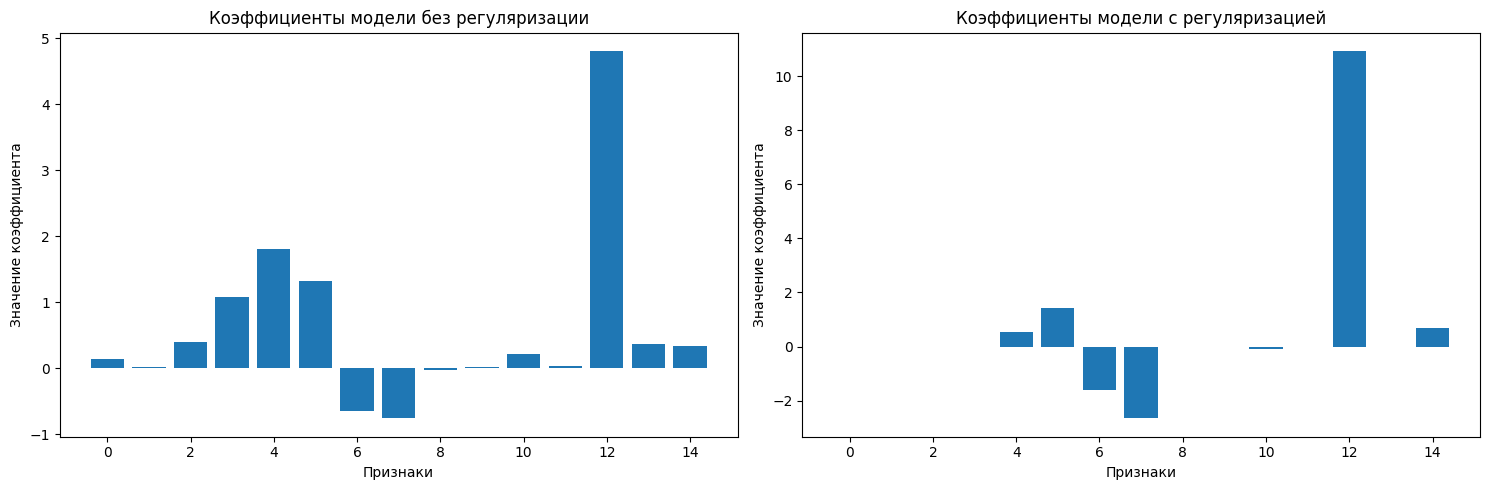

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [44]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.8250
Точность на тестовой выборке: 0.9500

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

Что?

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Нет

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [53]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [54]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [ ]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.8186841949428555
Точности по каждому фолду: [0.8261538461538461, 0.82, 0.8098537336412626, 0.821401077752117, 0.8160123171670516]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [ ]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.8176991150442477
Точности по каждому разделению: [0.8233936129280492, 0.8249326664101577, 0.8156983455175068, 0.8130050019238169, 0.8114659484417084]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [ ]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.8253846153846154
Точность на тестовых данных: 0.8067307692307693


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**